### RQ2: How do sentiment trends vary over time, particularly during significant events such as economic crisis (e.g., Brexit in UK) and COVID-19 pandemic, and are there notable differences in sentiment expressions during those specific phases?

In [10]:
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
from nltk.corpus import stopwords

In [7]:
# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Load the dataset
language_custom_2 = pd.read_csv('spelling_corrected_reviews.csv')
listings_df = pd.read_csv('final_apartment_df.csv')
calendar_df = pd.read_csv('calendar.csv',low_memory=False)

language_custom_2.rename(columns=lambda x: x.strip(), inplace=True)
listings_df.rename(columns=lambda x: x.strip(), inplace=True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Fix the column names
language_custom_2.rename(columns=lambda x: x.strip(), inplace=True)
listings_df.rename(columns=lambda x: x.strip(), inplace=True)

# Function to clean text and remove stop words
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

# Apply text cleaning
language_custom_2['processed_comments'] = language_custom_2['comments'].apply(clean_text)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to classify comments as positive, negative, or neutral using VADER
def classify_sentiment_vader(text):
    score = sid.polarity_scores(text)
    if score['compound'] > 0.05:
        return 'positive'
    elif score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis to the reviews DataFrame
language_custom_2['sentiment'] = language_custom_2['processed_comments'].apply(classify_sentiment_vader)

## Discussing during covid period

Price-related term counts during COVID-19 period:
{'hygiene': 0, 'cleanliness': 16, 'sanitization': 0, 'disinfect': 0, 'sanitized': 0, 'clean': 408, 'germ-free': 0, 'lockdown': 0, 'quarantine': 0, 'social distancing': 0, 'stay-at-home': 0, 'isolation': 0, 'travel restrictions': 0, 'health': 1, 'safety': 1, 'precautions': 2, 'health protocols': 0, 'safety measures': 0, 'virus': 0, 'pandemic': 4, 'COVID': 0, 'coronavirus': 1, 'mask': 2, 'PPE': 0, 'face shield': 0, 'impact': 0, 'effect': 0, 'concern': 0, 'risk': 1, 'stress': 1, 'emergency': 0, 'crisis': 0, 'restrictions': 3, 'guidelines': 1, 'protocols': 0, 'room service': 0, 'contactless': 0, 'remote': 2, 'virtual': 0, 'online': 1, 'curbside': 0, 'takeout': 0, 'delivery': 0, 'travel': 13, 'booking': 31, 'cancellation': 0, 'refund': 8, 'reschedule': 0, 'disruption': 1, 'capacity': 0, 'availability': 2, 'rate': 1}


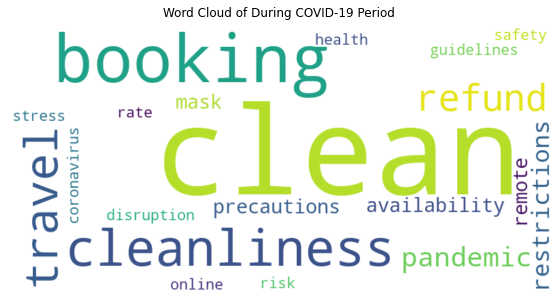

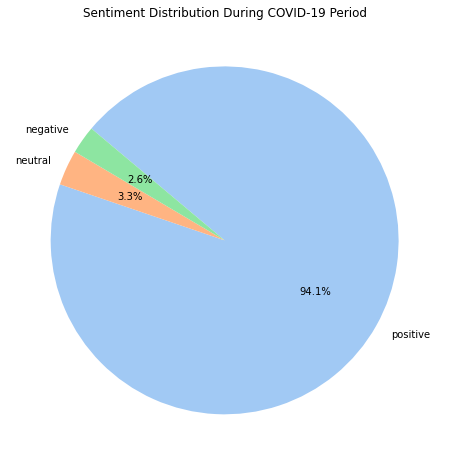

Sample reviews mentioning price-related terms during COVID-19 period:
                                                comments sentiment
12131  the location is extremely perfect you can go t...  positive
12093  amazing stay the apartment is exactly like the...  positive
8408   i was very disappointed after travelling 2 hou...  negative
8760   the flat was perfect for a few nights very cle...  positive
9521   brings place is bright and sunny and located j...  positive
8669                very stylish and clean place perfect  positive
11861  perfect place really useful flat amazing locat...  positive
502    great location clean and as described in the l...  positive
8333   reception was very helpful very clean better t...  positive
7029   perfect for a short stay great location checki...  positive


In [38]:
# Merge the reviews with listings data
merged_df = pd.merge(language_custom_2, listings_df, left_on='listing_id', right_on='listing_id', how='left')

# Extract price information from calendar.csv and merge it
calendar_df['price'] = calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)
average_price = calendar_df.groupby('listing_id')['price'].mean().reset_index()
average_price.rename(columns={'price': 'average_price'}, inplace=True)
merged_df = pd.merge(merged_df, average_price, on='listing_id', how='left')

# Filter reviews to the COVID-19 period
merged_df['date'] = pd.to_datetime(merged_df['date'])
covid_reviews = merged_df[(merged_df['date'] >= '2020-02-01') & (merged_df['date'] <= '2021-06-30')]

# Combine all comments during COVID-19 period
covid_comments = ' '.join(covid_reviews['comments'])

# Define price-related terms
price_related_terms = [
       'hygiene', 'cleanliness', 'sanitization', 'disinfect', 'sanitized', 'clean', 'germ-free',
    'lockdown', 'quarantine', 'social distancing', 'stay-at-home', 'isolation', 'travel restrictions',
    'health', 'safety', 'precautions', 'health protocols', 'safety measures', 'virus', 'pandemic', 
    'COVID', 'coronavirus', 'mask', 'PPE', 'face shield',
    'impact', 'effect', 'concern', 'risk', 'stress', 'emergency', 'crisis', 'restrictions', 
    'guidelines', 'protocols',
    'room service', 'contactless', 'remote', 'virtual', 'online', 'curbside', 'takeout', 'delivery',
    'travel', 'booking', 'cancellation', 'refund', 'reschedule', 'disruption', 'capacity', 'availability', 'rate'
]

# Count occurrences of price-related terms
word_counts = Counter(covid_comments.split())
price_term_counts = {term: word_counts[term] for term in price_related_terms}

# Display the counts of price-related terms
print("Price-related term counts during COVID-19 period:")
print(price_term_counts)

# Generate word cloud for price-related terms
price_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(price_term_counts)
plt.figure(figsize=(10, 5))
plt.imshow(price_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of During COVID-19 Period')
plt.show()

# Analyze sentiment distribution during COVID-19 period
covid_sentiment_counts = covid_reviews['sentiment'].value_counts()

# Plot pie chart with pastel colors
pastel_colors = sns.color_palette('pastel')
plt.figure(figsize=(8, 8))
plt.pie(covid_sentiment_counts, labels=covid_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=pastel_colors, counterclock=False)
plt.title('Sentiment Distribution During COVID-19 Period')
plt.show()

# Print sample reviews mentioning price-related terms during COVID-19 period
sample_price_reviews = covid_reviews[covid_reviews['comments'].str.contains('|'.join(price_related_terms))]
print("Sample reviews mentioning price-related terms during COVID-19 period:")
print(sample_price_reviews[['comments', 'sentiment']].sample(10))

## Discussion during Brexit period

Brexit-related term counts during Brexit period:
{'Brexit': 0, 'leave': 9, 'remain': 0, 'referendum': 0, 'European Union': 0, 'EU': 0, 'trade': 0, 'economy': 0, 'border': 0, 'migration': 0, 'immigration': 0, 'passport': 0, 'freedom of movement': 0, 'exit': 0, 'vote': 0, 'campaign': 0, 'sovereignty': 0, 'deal': 3, 'no-deal': 0, 'backstop': 0, 'customs union': 0, 'single market': 0, 'transition period': 0, 'Article 50': 0, 'negotiation': 0, 'agreement': 0, 'tariffs': 0, 'policy': 0, 'economic': 0, 'political': 0, 'impact': 0, 'uncertainty': 0, 'regulations': 0, 'restrictions': 0, 'business': 8, 'financial': 1, 'industry': 0, 'jobs': 0, 'currency': 0, 'pound': 0, 'sterling': 0, 'import': 0, 'export': 0}


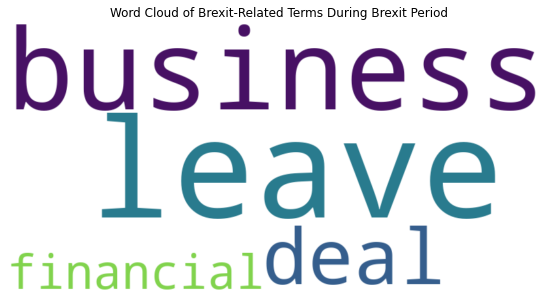

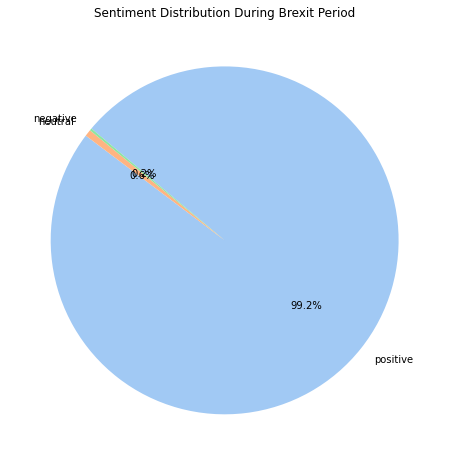

Sample reviews mentioning Brexit-related terms during Brexit period:
                                               comments sentiment
1250  peter went out of his way to make this a great...  positive
236   excellent choice i stylish comfortable flat th...  positive
1971  very small apartment and ideally suited to a c...  positive
418   we stayed in the room with three people and it...  positive
3098  the apartment is great as described perfect fo...  positive
417   great experience would definitely do again thi...  positive
1939  harder and his brother were very prompt friend...  positive
1571  we had a great time staying at the bromptons t...  positive
1634  lovely apartment spotlessly clean beautifully ...  positive
414   the studio was great it is in a good quiet loc...  positive


In [40]:
# Define the Brexit period
brexit_start = pd.to_datetime('2015-01-01')
brexit_end = pd.to_datetime('2016-06-23')  # Corrected the end date

# Filter reviews to the Brexit period
merged_df['date'] = pd.to_datetime(merged_df['date'])
brexit_reviews = merged_df[(merged_df['date'] >= brexit_start) & (merged_df['date'] <= brexit_end)]

# Combine all comments during the Brexit period
brexit_comments = ' '.join(brexit_reviews['comments'].dropna())  # Ensure there are no NaN values

# Define Brexit-related terms
brexit_related_terms = [
    'Brexit', 'leave', 'remain', 'referendum', 'European Union', 'EU', 'trade', 
    'economy', 'border', 'migration', 'immigration', 'passport', 'freedom of movement', 
    'exit', 'vote', 'campaign', 'sovereignty', 'deal', 'no-deal', 'backstop', 
    'customs union', 'single market', 'transition period', 'Article 50', 'negotiation', 
    'agreement', 'tariffs', 'policy', 'economic', 'political', 'impact', 
    'uncertainty', 'regulations', 'restrictions', 'business', 'financial', 
    'industry', 'jobs', 'currency', 'pound', 'sterling', 'import', 'export'
]

# Count occurrences of Brexit-related terms
brexit_word_counts = Counter(brexit_comments.split())
brexit_term_counts = {term: brexit_word_counts.get(term, 0) for term in brexit_related_terms}

# Display the counts of Brexit-related terms
print("Brexit-related term counts during Brexit period:")
print(brexit_term_counts)

# Generate word cloud for Brexit-related terms
brexit_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(brexit_term_counts)
plt.figure(figsize=(10, 5))
plt.imshow(brexit_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Brexit-Related Terms During Brexit Period')
plt.show()

# Analyze sentiment distribution during the Brexit period
brexit_sentiment_counts = brexit_reviews['sentiment'].value_counts()

# Plot pie chart with pastel colors
pastel_colors = sns.color_palette('pastel')
plt.figure(figsize=(8, 8))
plt.pie(brexit_sentiment_counts, labels=brexit_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=pastel_colors, counterclock=False)
plt.title('Sentiment Distribution During Brexit Period')
plt.show()

# Print sample reviews mentioning Brexit-related terms during Brexit period
sample_brexit_reviews = brexit_reviews[brexit_reviews['comments'].str.contains('|'.join(brexit_related_terms), na=False)]
print("Sample reviews mentioning Brexit-related terms during Brexit period:")
print(sample_brexit_reviews[['comments', 'sentiment']].sample(10))

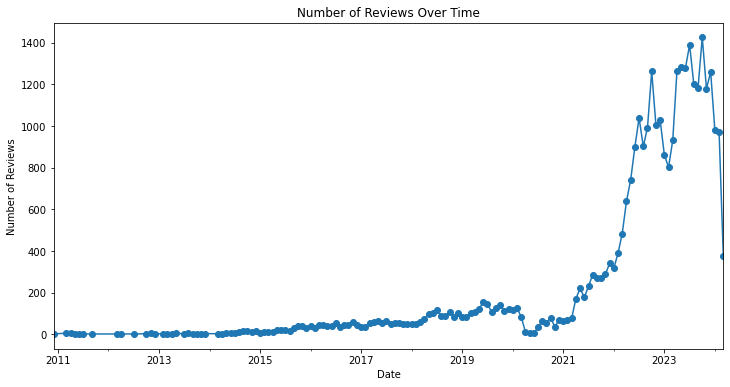

In [10]:
# Ensure the date column is in datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Group by month and count the number of reviews
monthly_reviews = merged_df.groupby(merged_df['date'].dt.to_period('M')).size()

# Plot the number of reviews over time
plt.figure(figsize=(12, 6))
monthly_reviews.plot(kind='line', marker='o')
plt.title('Number of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()


**Potential Reasons for the Trends During COVID:**

Drop in the Number of Reviews: The total number of reviews might have dropped during the COVID period. This can lead to fluctuations in the proportions of sentiments. With fewer reviews, the proportion of neutral and negative reviews can become more significant.
Travel Restrictions and Customer Experience: During the COVID period, travel restrictions, safety concerns, and other pandemic-related issues might have led to less enthusiastic reviews. Customers might have focused more on the factual and neutral aspects of their stays rather than expressing positive sentiments.
Changes in Expectations and Experiences: The expectations of travelers might have shifted during the pandemic. What was once considered a good experience might have been viewed differently under the stress and uncertainty of COVID.

## Sentiment trends and number of reviews over time

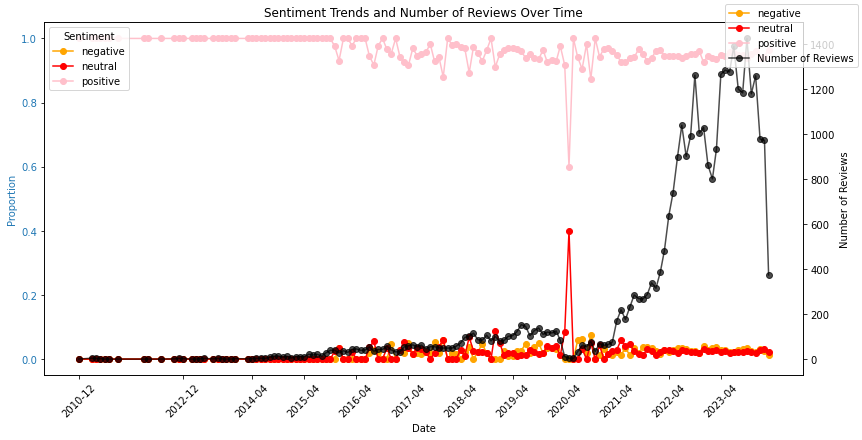

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'reviews_with_predicted_sentiment.csv'  # Replace with your actual file path
reviews_df_new = pd.read_csv(file_path)

# Ensure the 'date' column is in datetime format
reviews_df_new['date'] = pd.to_datetime(reviews_df_new['date'])

# Group by month and count the number of reviews
reviews_per_month = reviews_df_new.groupby(reviews_df_new['date'].dt.to_period('M')).size()

# Calculate the proportion of each sentiment category by month
sentiment_proportions = reviews_df_new.groupby(reviews_df_new['date'].dt.to_period('M'))['predicted_sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Define the colors for each sentiment
colors = {
    'negative': 'orange',
    'neutral': 'red',
    'positive': 'pink'
}

# Convert PeriodIndex to DatetimeIndex for plotting
sentiment_proportions.index = sentiment_proportions.index.to_timestamp()
reviews_per_month.index = reviews_per_month.index.to_timestamp()

# Convert indices and columns to numpy arrays for plotting
dates = sentiment_proportions.index.to_numpy()
reviews_per_month_array = reviews_per_month.to_numpy()

# Plot sentiment trends over time along with review counts
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot sentiment proportions
ax1.set_xlabel('Date')
ax1.set_ylabel('Proportion', color='tab:blue')
for sentiment in sentiment_proportions.columns:
    ax1.plot(dates, sentiment_proportions[sentiment].to_numpy(), marker='o', label=sentiment, color=colors[sentiment])
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(title='Sentiment', loc='upper left')

# Improve date label readability
ax1.set_xticks(dates[::12])  # Set ticks every 12 months
ax1.set_xticklabels(pd.to_datetime(dates[::12]).strftime('%Y-%m'), rotation=45)  # Format labels

# Create a secondary y-axis to plot the number of reviews
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Reviews', color='black')
ax2.plot(dates, reviews_per_month_array, marker='o', color='black', alpha=0.7, label='Number of Reviews')
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()
plt.title('Sentiment Trends and Number of Reviews Over Time')
fig.legend(loc='upper right')
plt.show()


In [16]:
# Ensure the 'date' column is in datetime format
reviews_df_new['date'] = pd.to_datetime(reviews_df_new['date'])

# Filter reviews for the month of April 2020
april_2020_reviews = reviews_df_new[(reviews_df_new['date'].dt.year == 2020) & (reviews_df_new['date'].dt.month == 4)]

# Count the number of total, positive, neutral, and negative reviews in April 2020
total_reviews_april_2020 = april_2020_reviews.shape[0]
positive_reviews_april_2020 = april_2020_reviews[april_2020_reviews['predicted_sentiment'] == 'positive'].shape[0]
neutral_reviews_april_2020 = april_2020_reviews[april_2020_reviews['predicted_sentiment'] == 'neutral'].shape[0]
negative_reviews_april_2020 = april_2020_reviews[april_2020_reviews['predicted_sentiment'] == 'negative'].shape[0]

total_reviews_april_2020, positive_reviews_april_2020, neutral_reviews_april_2020, negative_reviews_april_2020

(12, 11, 1, 0)

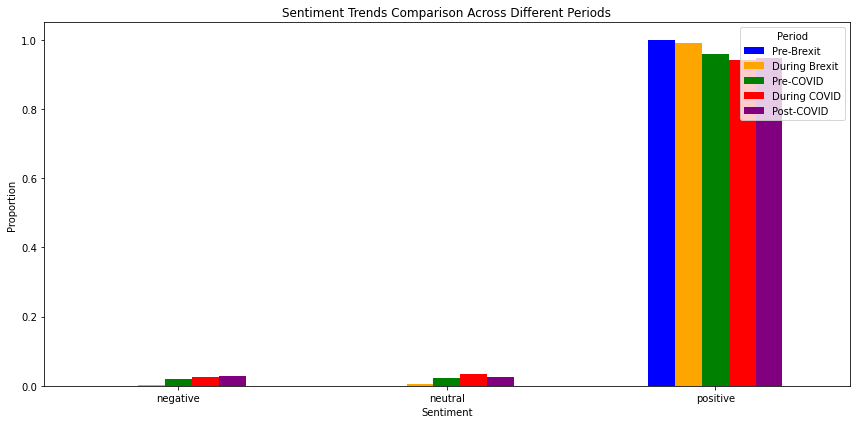

In [17]:
# Define the periods for comparison
periods = {
    "Pre-Brexit": (reviews_df_new['date'].min(), '2015-01-01'),
    "During Brexit": ('2015-01-01', '2016-06-01'),
    "Pre-COVID": (reviews_df_new['date'].min(), '2020-02-01'),
    "During COVID": ('2020-02-01', '2021-06-01'),
    "Post-COVID": ('2021-06-01', reviews_df_new['date'].max())
}

# Calculate the proportion of each sentiment category for each period
sentiment_proportions = {}
for period_name, (start_date, end_date) in periods.items():
    period_data = reviews_df_new[(reviews_df_new['date'] >= start_date) & (reviews_df_new['date'] < end_date)]
    sentiment_proportions[period_name] = period_data['predicted_sentiment'].value_counts(normalize=True)

# Create a DataFrame for comparison
sentiment_comparison_df = pd.DataFrame(sentiment_proportions).fillna(0)

# Define the colors for each period
colors = {
    "Pre-Brexit": 'blue',
    "During Brexit": 'orange',
    "Pre-COVID": 'green',
    "During COVID": 'red',
    "Post-COVID": 'purple'
}

# Plot sentiment trends comparison
sentiment_comparison_df.plot(kind='bar', figsize=(12, 6), color=[colors[period] for period in sentiment_comparison_df.columns])
plt.title('Sentiment Trends Comparison Across Different Periods')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Period', loc='upper right')
plt.tight_layout()
plt.show()

In [19]:
# Identify the date range for spikes in neutral reviews
neutral_review_spikes = reviews_df_new[(reviews_df_new['predicted_sentiment'] == 'neutral') & (reviews_df_new['date'] >= '2020-03-01')]

# Further narrow down the date range if necessary
spike_date_range = neutral_review_spikes['date'].value_counts().idxmax()

# Extract reviews around the spike date
spike_reviews = reviews_df_new[(reviews_df_new['date'] >= spike_date_range - pd.DateOffset(days=15)) & (reviews_df_new['date'] <= spike_date_range + pd.DateOffset(days=15))]

# Count the number of total, positive, neutral, and negative reviews during the spike period
total_reviews_spike_period = spike_reviews.shape[0]
positive_reviews_spike_period = spike_reviews[spike_reviews['predicted_sentiment'] == 'positive'].shape[0]
neutral_reviews_spike_period = spike_reviews[spike_reviews['predicted_sentiment'] == 'neutral'].shape[0]
negative_reviews_spike_period = spike_reviews[spike_reviews['predicted_sentiment'] == 'negative'].shape[0]

# Calculate the percentages
positive_percentage = (positive_reviews_spike_period / total_reviews_spike_period) * 100
neutral_percentage = (neutral_reviews_spike_period / total_reviews_spike_period) * 100
negative_percentage = (negative_reviews_spike_period / total_reviews_spike_period) * 100

(total_reviews_spike_period, positive_reviews_spike_period, positive_percentage, neutral_reviews_spike_period, neutral_percentage, negative_reviews_spike_period, negative_percentage)

(1020, 957, 93.82352941176471, 27, 2.6470588235294117, 36, 3.5294117647058822)

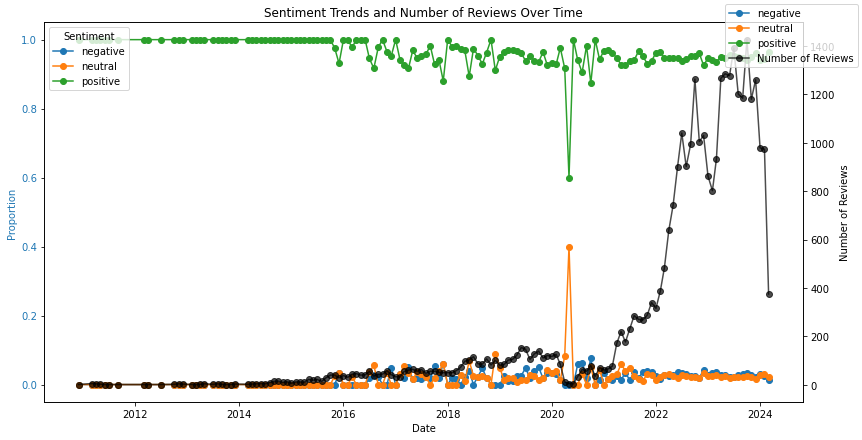

In [21]:
# Ensure the 'date' column is in datetime format
reviews_df_new['date'] = pd.to_datetime(reviews_df_new['date'])

# Calculate sentiment proportions over time
sentiment_proportions_over_time = reviews_df_new.groupby(reviews_df_new['date'].dt.to_period('M'))['predicted_sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Group by month and count the number of reviews
reviews_per_month = reviews_df_new.groupby(reviews_df_new['date'].dt.to_period('M')).size()
reviews_per_month.index = reviews_per_month.index.to_timestamp()

# Convert the index and columns to numpy arrays for plotting
dates = sentiment_proportions_over_time.index.to_timestamp().to_numpy()
reviews_per_month_array = reviews_per_month.to_numpy()

# Plot sentiment trends over time along with review counts
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot sentiment proportions
ax1.set_xlabel('Date')
ax1.set_ylabel('Proportion', color='tab:blue')
for sentiment in sentiment_proportions_over_time.columns:
    ax1.plot(dates, sentiment_proportions_over_time[sentiment].to_numpy(), marker='o', label=sentiment)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(title='Sentiment', loc='upper left')

# Create a secondary y-axis to plot the number of reviews
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Reviews', color='black')
ax2.plot(dates, reviews_per_month_array, marker='o', color='black', alpha=0.7, label='Number of Reviews')
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()
plt.title('Sentiment Trends and Number of Reviews Over Time')
fig.legend(loc='upper right')
plt.show()


## Sentiment trends during spike period (~2020)

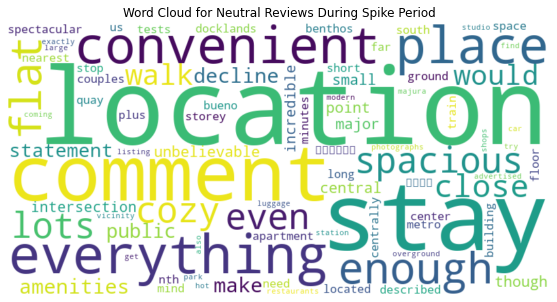

Most Common Words in Neutral Reviews During Spike Period:
location: 5
stay: 4
comment: 3
everything: 3
convenient: 3
place: 3
enough: 3
flat: 3
spacious: 2
lots: 2
cozy: 2
even: 2
close: 2
walk: 2
would: 2
amenities: 1
decline: 1
make: 1
public: 1
statement: 1


In [22]:
# Identify the date range for spikes in neutral reviews
neutral_review_spikes = reviews_df_new[(reviews_df_new['predicted_sentiment'] == 'neutral') & (reviews_df_new['date'] >= '2020-03-01')]

# Further narrow down the date range if necessary
spike_date_range = neutral_review_spikes['date'].value_counts().idxmax()

# Extract reviews around the spike date
spike_reviews = reviews_df_new[(reviews_df_new['date'] >= spike_date_range - pd.DateOffset(days=15)) & (reviews_df_new['date'] <= spike_date_range + pd.DateOffset(days=15))]

# Filter for neutral reviews during the spike period
neutral_reviews_spike_period = spike_reviews[spike_reviews['predicted_sentiment'] == 'neutral']

# Display the neutral reviews
neutral_reviews_spike_period[['date', 'comments']]

# Generate a word cloud for neutral reviews
text = ' '.join(neutral_reviews_spike_period['comments'].dropna())
wordcloud = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Reviews During Spike Period')
plt.show()

# Get the most common words
words = text.split()
filtered_words = [word for word in words if word.lower() not in stop_words and word.isalpha()]
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)

print("Most Common Words in Neutral Reviews During Spike Period:")
for word, count in common_words:
    print(f"{word}: {count}")

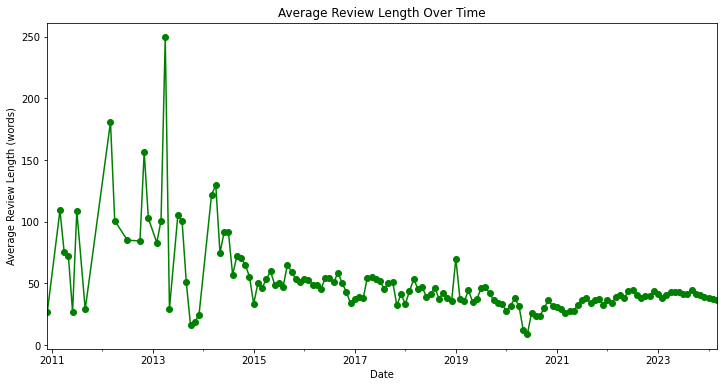

In [23]:
# Calculate the length of each review
reviews_df_new['review_length'] = reviews_df_new['comments'].apply(lambda x: len(str(x).split()))

# Group by month and calculate the average review length
average_review_length_per_month = reviews_df_new.groupby(reviews_df_new['date'].dt.to_period('M'))['review_length'].mean()

# Plot the average review length over time
plt.figure(figsize=(12, 6))
average_review_length_per_month.plot(kind='line', marker='o', color='green')
plt.title('Average Review Length Over Time')
plt.xlabel('Date')
plt.ylabel('Average Review Length (words)')
plt.show()

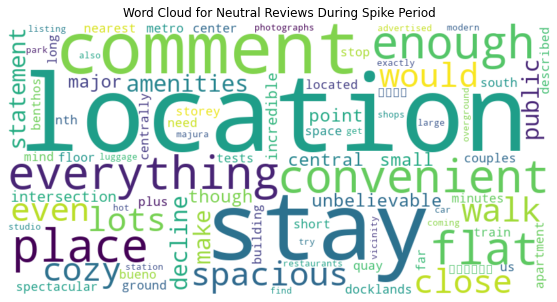

Most Common Words in Neutral Reviews During Spike Period:
location: 5
stay: 4
comment: 3
everything: 3
convenient: 3
place: 3
enough: 3
flat: 3
spacious: 2
lots: 2
cozy: 2
even: 2
close: 2
walk: 2
would: 2
amenities: 1
decline: 1
make: 1
public: 1
statement: 1


In [25]:
# Identify the date range for spikes in neutral reviews
neutral_review_spikes = reviews_df_new[(reviews_df_new['predicted_sentiment'] == 'neutral') & (reviews_df_new['date'] >= '2020-03-01')]

# Further narrow down the date range if necessary
spike_date_range = neutral_review_spikes['date'].value_counts().idxmax()

# Extract reviews around the spike date
spike_reviews = reviews_df_new[(reviews_df_new['date'] >= spike_date_range - pd.DateOffset(days=15)) & (reviews_df_new['date'] <= spike_date_range + pd.DateOffset(days=15))]

# Filter for neutral reviews during the spike period
neutral_reviews_spike_period = spike_reviews[spike_reviews['predicted_sentiment'] == 'neutral']

# Display the neutral reviews
neutral_comments = neutral_reviews_spike_period['comments'].dropna().tolist()

# Generate a word cloud for neutral reviews
text = ' '.join(neutral_comments)
wordcloud = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Reviews During Spike Period')
plt.show()

# Get the most common words
words = text.split()
filtered_words = [word for word in words if word.lower() not in stop_words and word.isalpha()]
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)

print("Most Common Words in Neutral Reviews During Spike Period:")
for word, count in common_words:
    print(f"{word}: {count}")

# Save the detailed review content to analyze further
neutral_reviews_spike_period[['date', 'comments']].to_csv('neutral_reviews_spike_period.csv', index=False)

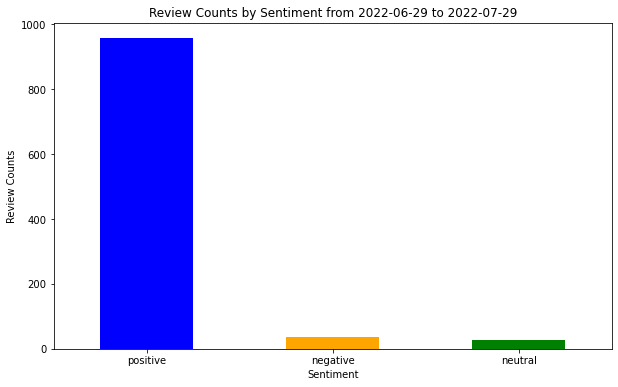

predicted_sentiment
positive    957
negative     36
neutral      27
Name: count, dtype: int64

In [26]:
# Identify the date range for spikes in neutral reviews
neutral_review_spikes = reviews_df_new[(reviews_df_new['predicted_sentiment'] == 'neutral') & (reviews_df_new['date'] >= '2020-03-01')]

# Further narrow down the date range if necessary
spike_date_range = neutral_review_spikes['date'].value_counts().idxmax()

# Extract reviews around the spike date
spike_start_date = spike_date_range - pd.DateOffset(days=15)
spike_end_date = spike_date_range + pd.DateOffset(days=15)
spike_reviews = reviews_df_new[(reviews_df_new['date'] >= spike_start_date) & (reviews_df_new['date'] <= spike_end_date)]

# Calculate review counts for each sentiment during the spike period
review_counts = spike_reviews['predicted_sentiment'].value_counts()

# Plot the review counts
plt.figure(figsize=(10, 6))
review_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title(f'Review Counts by Sentiment from {spike_start_date.date()} to {spike_end_date.date()}')
plt.xlabel('Sentiment')
plt.ylabel('Review Counts')
plt.xticks(rotation=0)
plt.show()

# Display the counts
review_counts

In [27]:
# Identify the spike period
spike_date_range = reviews_df_new['date'].dt.to_period('M').value_counts().idxmax()

# Extract reviews around the spike date
spike_reviews = reviews_df_new[reviews_df_new['date'].dt.to_period('M') == spike_date_range]

# Calculate the number of reviews for each sentiment during the spike period
review_counts_during_spike = spike_reviews['predicted_sentiment'].value_counts()

review_counts_during_spike

predicted_sentiment
positive    1340
negative      49
neutral       37
Name: count, dtype: int64

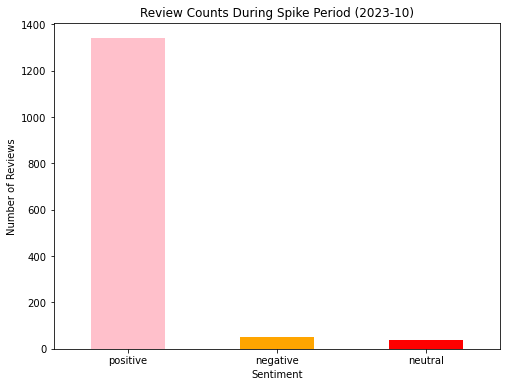

Proportions during spike period:
Positive: 0.9397
Neutral: 0.0259
Negative: 0.0344


In [28]:
# Review counts during the spike period
review_counts_during_spike = pd.Series({
    'positive': 1340,
    'negative': 49,
    'neutral': 37
})

# Plot the review counts
plt.figure(figsize=(8, 6))
review_counts_during_spike.plot(kind='bar', color=['pink', 'orange', 'red'])
plt.title(f'Review Counts During Spike Period ({spike_date_range})')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

# Calculate and print proportions for clarity
positive_proportion = review_counts_during_spike['positive'] / review_counts_during_spike.sum()
neutral_proportion = review_counts_during_spike['neutral'] / review_counts_during_spike.sum()
negative_proportion = review_counts_during_spike['negative'] / review_counts_during_spike.sum()

print(f"Proportions during spike period:\nPositive: {positive_proportion:.4f}\nNeutral: {neutral_proportion:.4f}\nNegative: {negative_proportion:.4f}")

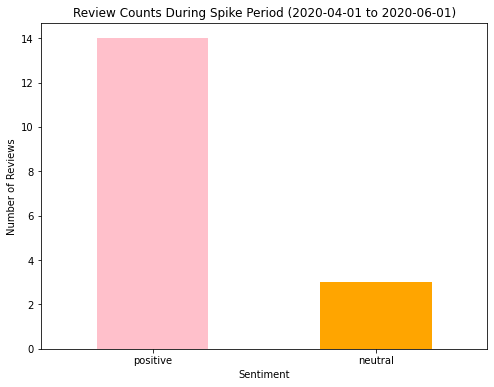

Proportions during spike period:
Positive: 0.8235
Neutral: 0.1765
Negative: 0.0000
Total Reviews: 17
Date Range of Spike: 2020-04-01 to 2020-06-01


In [31]:
# Calculate the proportion of each sentiment category by month
sentiment_proportions = reviews_df_new.groupby(reviews_df_new['date'].dt.to_period('M'))['predicted_sentiment'].value_counts(normalize=True).unstack().fillna(0)

# Identify the spike period (highest month for neutral sentiment)
spike_month = sentiment_proportions['neutral'].idxmax()

# Define the date range (one month before and after the spike month)
spike_start_date = spike_month.to_timestamp() - pd.DateOffset(months=1)
spike_end_date = spike_month.to_timestamp() + pd.DateOffset(months=1)

# Extract reviews around the spike date
spike_reviews = reviews_df_new[(reviews_df_new['date'] >= spike_start_date) & (reviews_df_new['date'] <= spike_end_date)]

# Calculate the number of reviews for each sentiment during the spike period
review_counts_during_spike = spike_reviews['predicted_sentiment'].value_counts()

# Plot the review counts
plt.figure(figsize=(8, 6))
review_counts_during_spike.plot(kind='bar', color=['pink', 'orange', 'red'])
plt.title(f'Review Counts During Spike Period ({spike_start_date.date()} to {spike_end_date.date()})')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

# Calculate and print proportions for clarity
total_reviews_during_spike = review_counts_during_spike.sum()
positive_proportion = review_counts_during_spike.get('positive', 0) / total_reviews_during_spike
neutral_proportion = review_counts_during_spike.get('neutral', 0) / total_reviews_during_spike
negative_proportion = review_counts_during_spike.get('negative', 0) / total_reviews_during_spike

print(f"Proportions during spike period:\nPositive: {positive_proportion:.4f}\nNeutral: {neutral_proportion:.4f}\nNegative: {negative_proportion:.4f}")
print(f"Total Reviews: {total_reviews_during_spike}")
print(f"Date Range of Spike: {spike_start_date.date()} to {spike_end_date.date()}")

- The spike in neutral reviews is primarily due to the low number of total reviews during the early COVID-19 period. A small number of neutral reviews have a more substantial impact on proportions when the total review count is low.

- During the spike period, while the number of neutral reviews is small, their proportion becomes noticeable due to the method of normalization used in the plotting.

## Sentiment trends across COVID-19 

**Define Periods:**

- Pre-COVID: Before March 2020
- During COVID: March 2020 to June 2021
- Post-COVID: After June 2021

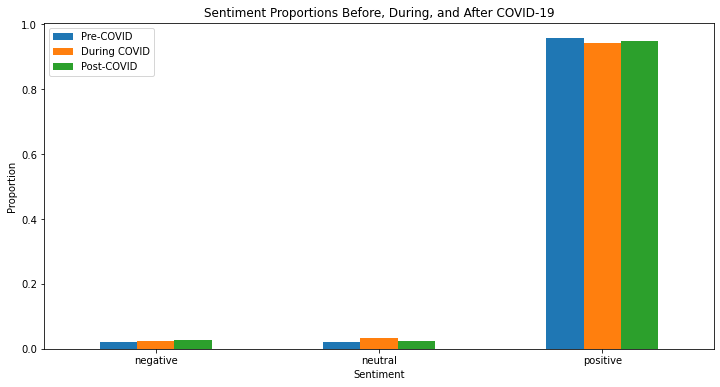

In [32]:
# Define periods
pre_covid = reviews_df_new[reviews_df_new['date'] < '2020-03-01']
during_covid = reviews_df_new[(reviews_df_new['date'] >= '2020-03-01') & (reviews_df_new['date'] <= '2021-06-01')]
post_covid = reviews_df_new[reviews_df_new['date'] > '2021-06-01']

# Function to calculate sentiment proportions
def calculate_proportions(df):
    return df['predicted_sentiment'].value_counts(normalize=True)

# Calculate proportions for each period
pre_covid_proportions = calculate_proportions(pre_covid)
during_covid_proportions = calculate_proportions(during_covid)
post_covid_proportions = calculate_proportions(post_covid)

# Combine proportions into a DataFrame
proportions_df = pd.DataFrame({
    'Pre-COVID': pre_covid_proportions,
    'During COVID': during_covid_proportions,
    'Post-COVID': post_covid_proportions
}).fillna(0)

# Plot sentiment proportions
proportions_df.plot(kind='bar', figsize=(12, 6))
plt.title('Sentiment Proportions Before, During, and After COVID-19')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

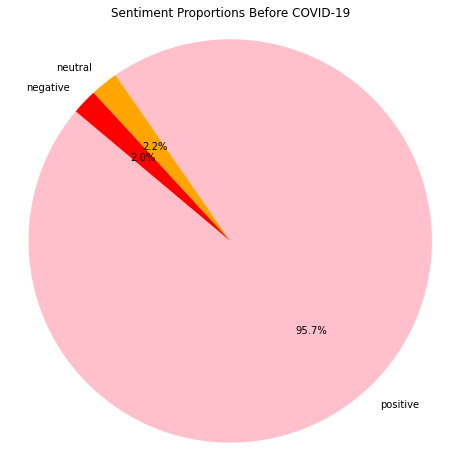

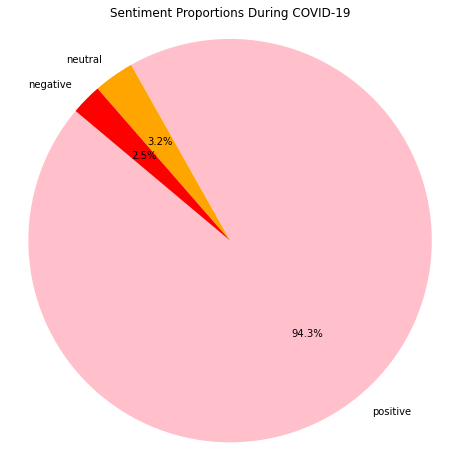

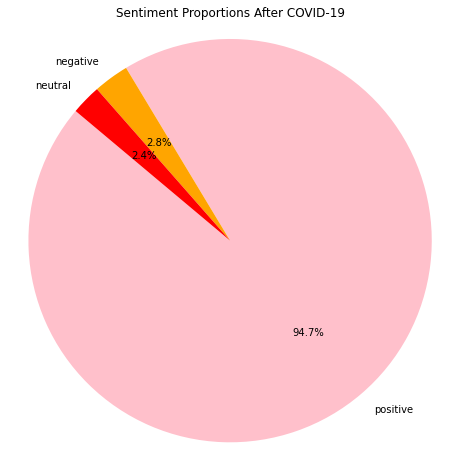

In [34]:
# Function to calculate sentiment counts and proportions
def calculate_counts(df):
    return df['predicted_sentiment'].value_counts()

# Calculate counts for each period
pre_covid_counts = calculate_counts(pre_covid)
during_covid_counts = calculate_counts(during_covid)
post_covid_counts = calculate_counts(post_covid)

# Function to plot pie chart
def plot_pie_chart(counts, title):
    labels = counts.index
    sizes = counts.values
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['pink', 'orange', 'red'])
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Plot pie charts
plot_pie_chart(pre_covid_counts, 'Sentiment Proportions Before COVID-19')
plot_pie_chart(during_covid_counts, 'Sentiment Proportions During COVID-19')
plot_pie_chart(post_covid_counts, 'Sentiment Proportions After COVID-19')

In [36]:
print(during_covid.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1048 entries, 84 to 13727
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0    listing_id          1048 non-null   int64         
 1   id                   1048 non-null   int64         
 2   date                 1048 non-null   datetime64[ns]
 3   reviewer_id          1048 non-null   int64         
 4   reviewer_name        1048 non-null   object        
 5   comments             1048 non-null   object        
 6   language             1048 non-null   object        
 7   processed_comments   1044 non-null   object        
 8   sentiment            1048 non-null   object        
 9   label                1048 non-null   int64         
 10  predicted_sentiment  1048 non-null   object        
 11  review_length        1048 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 106.4+ KB
None


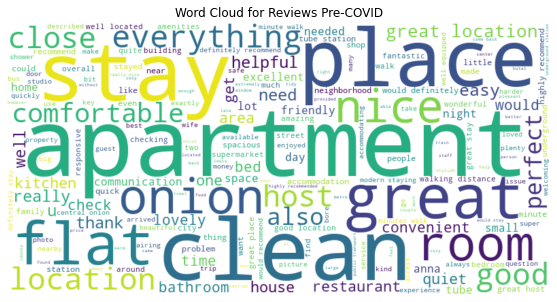

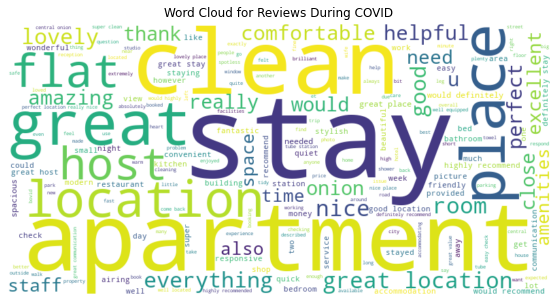

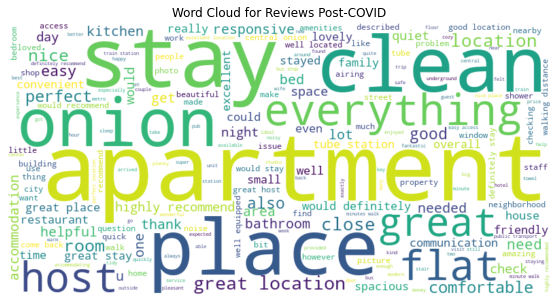

Common Words Pre-COVID: [('great', 2083), ('apartment', 1706), ('stay', 1700), ('location', 1582), ('place', 1395), ('clean', 1360), ('onion', 1097), ('good', 1038), ('nice', 993), ('flat', 885), ('would', 867), ('room', 800), ('well', 784), ('host', 752), ('close', 752), ('recommend', 745), ('station', 731), ('everything', 711), ('us', 665), ('comfortable', 642)]

Common Words During COVID: [('great', 534), ('stay', 451), ('location', 417), ('place', 325), ('clean', 323), ('apartment', 310), ('would', 207), ('good', 195), ('nice', 173), ('host', 166), ('flat', 160), ('recommend', 151), ('lovely', 140), ('definitely', 127), ('everything', 120), ('perfect', 115), ('comfortable', 114), ('really', 112), ('room', 112), ('well', 107)]

Common Words Post-COVID: [('great', 13286), ('stay', 12660), ('location', 11199), ('apartment', 10638), ('place', 8686), ('clean', 7856), ('good', 6204), ('onion', 6166), ('would', 5919), ('host', 5420), ('nice', 5156), ('well', 4567), ('everything', 4459), (

In [33]:
# Function to generate word cloud and common words
def generate_word_analysis(df, title):
    text = ' '.join(df['comments'].dropna())
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words and word.isalpha()]
    word_counts = Counter(filtered_words)
    common_words = word_counts.most_common(20)
    return common_words

# Generate word clouds and common words for each period
pre_covid_common_words = generate_word_analysis(pre_covid, 'Word Cloud for Reviews Pre-COVID')
during_covid_common_words = generate_word_analysis(during_covid, 'Word Cloud for Reviews During COVID')
post_covid_common_words = generate_word_analysis(post_covid, 'Word Cloud for Reviews Post-COVID')

# Display common words
print("Common Words Pre-COVID:", pre_covid_common_words)
print("\nCommon Words During COVID:", during_covid_common_words)
print("\nCommon Words Post-COVID:", post_covid_common_words)

- Visualize Sentiment Proportions: Compare how the proportions of positive, neutral, and negative sentiments changed across the three periods.

- Identify Common Themes: Use word clouds and lists of common words to understand changes in the topics and language used in reviews.